In [81]:
import cv2
from matplotlib import pyplot as plt
import numpy as np

#image = cv2.imread("samples/2_7mUR_original-test_1609981034838.jpg")
image = cv2.imread("samples/IMG_20201127_235047.jpg")

def resize_image(image, scale_percent):
    # Get original image dimensions
    width = int(image.shape[1])
    height = int(image.shape[0])

    # Calculate the new dimensions
    new_width = int(width * scale_percent / 100)
    new_height = int(height * scale_percent / 100)

    # Resize image
    resized_image = cv2.resize(image, (new_width, new_height))

    return resized_image

def preprocess_image(image, resize_shape=None, noise_reduction=True, blur_kernel=(5, 5), grayscale=False):
    """
    Preprocesses an image for computer vision tasks.

    Args:
        image: The input image as a NumPy array.
        resize_shape: A tuple (width, height) to resize the image to. Defaults to None (no resizing).
        noise_reduction: A boolean flag indicating whether to apply noise reduction (default: True).
        blur_kernel: A tuple (width, height) specifying the kernel size for blurring (default: (5, 5)).
        grayscale: A boolean flag indicating whether to convert the image to grayscale (default: False).

    Returns:
        The preprocessed image as a NumPy array.
    """

    # Copy the image to avoid modifying the original
    preprocessed_image = image.copy()

    # Resize if desired
    if resize_shape is not None:
        preprocessed_image = cv2.resize(preprocessed_image, resize_shape, interpolation=cv2.INTER_AREA)

    # Convert to grayscale if needed
    if grayscale:
        preprocessed_image = cv2.cvtColor(preprocessed_image, cv2.COLOR_BGR2GRAY)

    # Noise Reduction (optional)
    #if noise_reduction:
        # Apply bilateral filtering for noise reduction and edge preservation
        #preprocessed_image = cv2.bilateralFiltering(preprocessed_image, 9, 75, 75)

    # apply clahe
    #clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    #preprocessed_image = clahe.apply(preprocessed_image)
    """ clahe do hsv
    hsv_image = cv2.cvtColor(preprocessed_image, cv2.COLOR_BGR2HSV)

    # Apply CLAHE to the Value channel
    clahe = cv2.createCLAHE(clipLimit=1.0, tileGridSize=(12, 12))
    hsv_image[:, :, 2] = clahe.apply(hsv_image[:, :, 2])

    # Convert back to BGR colorspace
    preprocessed_image = cv2.cvtColor(hsv_image, cv2.COLOR_HSV2BGR)
    """
    """ clahe do lab

    # Convert the image to LAB color space
    lab_image = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)

    # Split the LAB image into channels
    l, a, b = cv2.split(lab_image)

    # Apply CLAHE to the L channel
    clahe = cv2.createCLAHE(clipLimit=1.0, tileGridSize=(10, 10))
    l_clahe = clahe.apply(l)

    # Merge the CLAHE enhanced L channel with the original A and B channels
    lab_image_clahe = cv2.merge((l_clahe, a, b))

    # Convert the LAB image back to BGR color space
    preprocessed_image = cv2.cvtColor(lab_image_clahe, cv2.COLOR_LAB2BGR)
    """


    # Blurring (optional)
    #if blur_kernel[0] > 1 and blur_kernel[1] > 1:
        #preprocessed_image = cv2.blur(preprocessed_image, blur_kernel)
    preprocessed_image = cv2.medianBlur(preprocessed_image, 9)


    return preprocessed_image

image = resize_image(image, 10)
image = preprocess_image(image, resize_shape=(400, 400), noise_reduction=True, blur_kernel=(9, 9), grayscale=False)

hist = cv2.calcHist([image], [0, 1, 2], None, [32, 32, 32], [0, 256, 0, 256, 0, 256])

# Plot the histogram

# Thresholding
threshold = 0.075 * hist.sum()
num_colors = np.sum(hist > threshold)
print("Number of distinct colors:", num_colors)



cv2.imshow("Image", image)
cv2.waitKey(0)
cv2.destroyAllWindows()

Number of distinct colors: 4


In [ ]:

# multi level threasholding
image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
ret, thresh1 = cv2.threshold(image_gray, 127, 255, cv2.THRESH_BINARY)
ret, thresh2 = cv2.threshold(image_gray, 127, 255, cv2.THRESH_BINARY_INV)
ret, thresh3 = cv2.threshold(image_gray, 127, 255, cv2.THRESH_TRUNC)
ret, thresh4 = cv2.threshold(image_gray, 127, 255, cv2.THRESH_TOZERO)
ret, thresh5 = cv2.threshold(image_gray, 127, 255, cv2.THRESH_TOZERO_INV)
titles = ['Original Image', 'BINARY', 'BINARY_INV', 'TRUNC', 'TOZERO', 'TOZERO_INV']
images = [image_gray, thresh1, thresh2, thresh3, thresh4, thresh5]

for i in range(6):
    plt.subplot(2, 3, i+1), plt.imshow(images[i], 'gray')
    plt.title(titles[i])
    plt.xticks([]), plt.yticks([])
plt.show()


In [72]:

reshaped_image = image.reshape((-1,3))
reshaped_image = np.float32(reshaped_image)

print(f"Current shape: {reshaped_image.shape}")

# Define criteria and number of clusters (k)
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
k = 3

# Apply K-means
ret, label, center = cv2.kmeans(reshaped_image, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)

# Convert back to uint8, and make resulting image
center = np.uint8(center)
result = center[label.flatten()]
result = result.reshape((image.shape))

# Show image
cv2.imshow('Image', image)
cv2.imshow('K-Means Result', result)
cv2.waitKey(0)
cv2.destroyAllWindows()

Current shape: (160000, 3)


## K-means clustering with elbow method

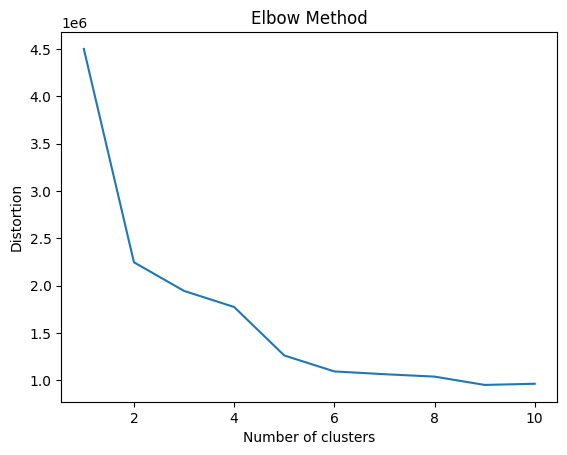

Optimal number of clusters: 4


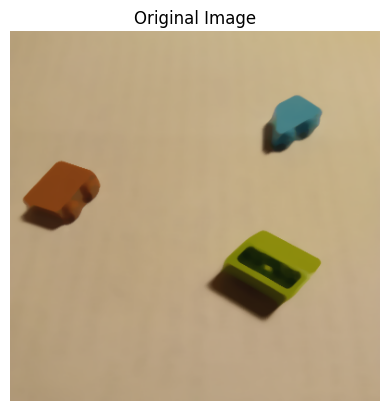

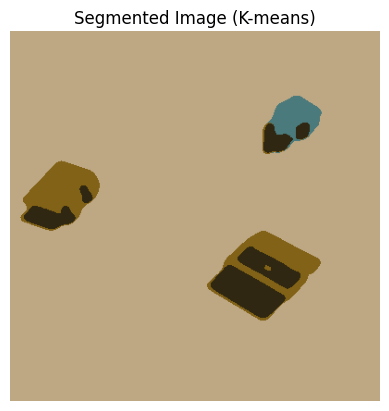

In [82]:

# Reshape image
reshaped_image = image.reshape((-1, 3))
reshaped_image = np.float32(reshaped_image)

# Define criteria
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)

# List to hold distortions
distortions = []

# Maximum number of clusters to try
max_clusters = 10

for k in range(1, max_clusters+1):
    # Apply K-means
    ret, label, center = cv2.kmeans(reshaped_image, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)
    
    # Calculate distortion (difference between colors)
    distortion = 0
    for i in range(len(reshaped_image)):
        distortion += np.linalg.norm(reshaped_image[i] - center[label[i][0]])
    distortions.append(distortion)
    

# Plot distortions
plt.plot(range(1, max_clusters+1), distortions)
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.title('Elbow Method')
plt.show()

# Automatically choose the number of clusters (k)
optimal_k = np.argmin(np.diff(distortions)) + 1+3

print("Optimal number of clusters:", optimal_k)

# Apply K-means with optimal number of clusters
ret, label, center = cv2.kmeans(reshaped_image, optimal_k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)

# Convert center values back to uint8
center = np.uint8(center)

# Create the segmented image
segmented_image = center[label.flatten()]
segmented_image = segmented_image.reshape(image.shape)

# Show images
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title('Original Image')
plt.axis('off')
plt.show()

plt.imshow(cv2.cvtColor(segmented_image, cv2.COLOR_BGR2RGB))
plt.title('Segmented Image (K-means)')
plt.axis('off')
plt.show()


## K-means clustering with silhouette method

/home/jose.l.rodrigues/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jose.l.rodrigues/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jose.l.rodrigues/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jose.l.rodrigues/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d

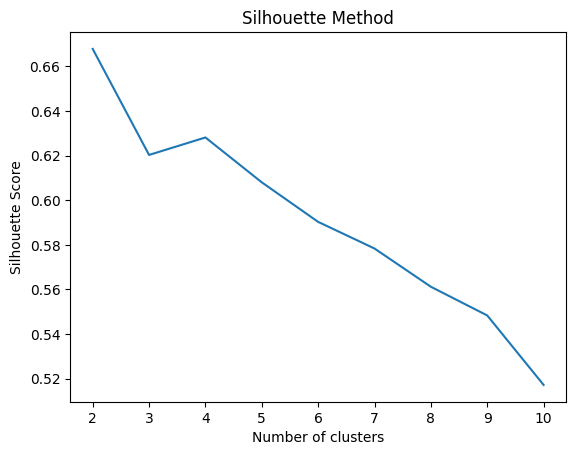

Optimal number of clusters: 2


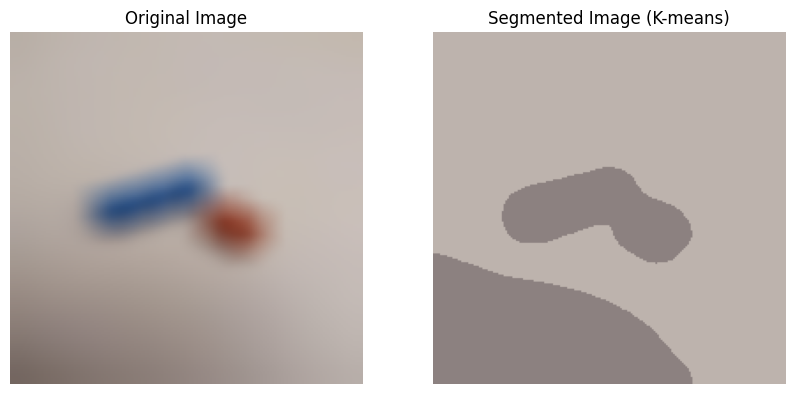

In [24]:
from sklearn.metrics import silhouette_score

# Convert image to RGB color space
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Reshape image to a list of pixels
reshaped_image = image_rgb.reshape((-1, 3))

# Convert pixel values to float32 for K-means
reshaped_image = np.float32(reshaped_image)

# Define criteria
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)

# List to hold silhouette scores
silhouette_scores = []

# Maximum number of clusters to try
max_clusters = 10

for k in range(2, max_clusters+1):  # Starting from 2 clusters
    # Apply K-means
    _, labels, centers = cv2.kmeans(reshaped_image, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)
    
    # Calculate silhouette score
    silhouette_avg = silhouette_score(reshaped_image, labels)
    silhouette_scores.append(silhouette_avg)

# Plot silhouette scores
plt.plot(range(2, max_clusters+1), silhouette_scores)
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Method')
plt.show()

# Automatically choose the number of clusters (k) with the highest silhouette score
optimal_k = np.argmax(silhouette_scores) + 2  # Add 2 since we started from 2 clusters

print("Optimal number of clusters:", optimal_k)

# Apply K-means with optimal number of clusters
_, labels, centers = cv2.kmeans(reshaped_image, optimal_k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)

# Convert center values back to uint8
centers = np.uint8(centers)

# Map each pixel to its corresponding cluster center
segmented_image = centers[labels.flatten()]

# Reshape segmented image to match original image shape
segmented_image = segmented_image.reshape(image_rgb.shape)

# Display original and segmented images
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(image_rgb)
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(segmented_image)
plt.title('Segmented Image (K-means)')
plt.axis('off')

plt.show()


In [86]:
# Define image mask for the GrabCut output with same dimensions as the image
mask = np.zeros(image.shape[:2], np.uint8)

# Define the bounding box coordinates with the object of interest: (x, y, width, heigh)
roi = (0, 0, 399, 399)

# Allocate memory for the two arrays that this algorithm internally uses for the segmentation of the foreground and background
bgModel = np.zeros((1, 65), np.float64)
fgModel = np.zeros((1, 65), np.float64)

# Apply GrabCut
(mask, bgModel, fgModel) = cv2.grabCut(image, mask, roi, bgModel, fgModel, 500, cv2.GC_INIT_WITH_RECT)

# All definite background and probable background pixels are set to 0, and all definite foreground and probable foreground pixels are set to 1
output_mask = np.where((mask == cv2.GC_BGD) | (mask == cv2.GC_PR_BGD), 0, 1)

# Scale the mask from the range [0, 1] to [0, 255]
output_mask = (output_mask * 255).astype("uint8")

# Apply a bitwise AND to the image using the generated mask by GrabCut to obtain the final result
grabcut_result = cv2.bitwise_and(image, image, mask=output_mask)

# Show result
cv2.imshow('Output Mask', output_mask)
cv2.imshow('GrabCut Result', grabcut_result)
cv2.waitKey(0)
cv2.destroyAllWindows()